# Solve frozen lake with Deep Q Network

Solve the [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/) environment using the Deep Q Network (DQN) method with epsilon-greedy action selection, experience replay and a target network.

This approach employs a Q-function which can be updated using bootstrapping:

$$
Q(s,a;\theta) = r + \gamma \max_{a'} Q(s',a';\theta') \ .
$$

Since we use a neural network to represent $Q$, we cannot do this assignment directly, but instead perform a gradient update using squared loss: 

$$
L(\theta) = \mathbb{E}_{s,a,r,s'}[(r + \gamma \max_{a'} Q(s',a';\theta') - Q(s,a;\theta))^2] \ ,
$$

with transitions $(s,a,r,s')$ sampled from an experience replay memory. 

Notice how the implementation uses a different set of parameters, $\theta'$, to compute the target value. This is the target network parameters which are a delayed copy of $\theta$.
The implementation below uses "soft" target updates rather than copying the weights periodically:

$$
\theta' = \tau \theta + (1-\tau) \theta' \ ,
$$

with $\tau \ll 1$.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gym
from collections import deque

In [2]:
# initialize environment
env = gym.make('FrozenLake-v0')

[2017-12-20 15:42:57,231] Making new env: FrozenLake-v0


In [3]:
# show initial state
s = env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [4]:
class ReplayMemory(object):
    """Experience Replay Memory"""
    
    def __init__(self, size):
        self.size = size
        self.memory = deque(maxlen=size)
    
    def add(self, s, a, r, s1, d):
        """Add experience to memory."""
        self.memory.append((s, a, r, s1, d))
    
    def sample(self, batch_size, replace=False):
        """Sample batch of experiences from memory with replacement."""
        idx = np.random.choice(len(self.memory), batch_size, replace=replace)
        batch = np.array([self.memory[i] for i in idx]).T
        s, a, r, s1, d = batch[0], batch[1], batch[2], batch[3], batch[4]
        return s.astype(int), a.astype(int), r, s1.astype(int), d
    
    @property
    def count(self):
        return len(self.memory)

In [5]:
class QNetwork(object):
    """Q-network with target network"""
    
    def __init__(self, n_inputs, n_outputs, learning_rate, tau, scope='qnet'):
        # setup main net
        with tf.variable_scope(scope):
            self.states, self.out = self._create_net(n_inputs, n_outputs)
            self.trainables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope)
            self.targets = tf.placeholder(tf.float32, [None, n_outputs], name='targets')
            self.loss = tf.reduce_sum(tf.square(self.targets - self.out))
            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            self.update = self.optimizer.minimize(self.loss)
        # setup target net
        target_scope = '%s_target' % scope
        with tf.variable_scope(target_scope):
            self.target_states, self.target_out = self._create_net(n_inputs, n_outputs)
            self.target_trainables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=target_scope) 
            self.copy_target = self._assign_target_trainables(tau=1.0)
            self.update_target = self._assign_target_trainables(tau=tau)

    def _create_net(self, n_inputs, n_outputs):
        states = tf.placeholder(tf.float32, [None, n_inputs], name='states')
        out = tf.layers.dense(inputs=states, units=n_outputs, activation=None, name='out')
        return states, out
    
    def _assign_target_trainables(self, tau):
        # ops for copying trainables from the main net to the target net with rate tau
        return [t.assign((1-tau) * t.value() + tau * self.trainables[i].value()) \
                for i, t in enumerate(self.target_trainables)]

In [6]:
# one-hot encoder for the states
def one_hot(i, l):
    a = np.zeros((len(i), l))
    a[range(len(i)), i] = 1
    return a

In [7]:
# train Q-network

num_episodes = 1000
episode_limit = 100
batch_size = 64
learning_rate = 0.005
gamma = 0.99 # discount rate
tau = 0.001 # target network update rate
replay_memory_size = 10000
prefill_memory = True

print_freq = 100

n_state = env.observation_space.n
n_action = env.action_space.n

# initialize Q-network
tf.reset_default_graph()
qnet = QNetwork(n_state, n_action, learning_rate, tau)

# initialize replay memory
replay_memory = ReplayMemory(replay_memory_size)
if prefill_memory:
    print('prefill memory')
    s = env.reset()
    while replay_memory.count < replay_memory.size:
        a = env.action_space.sample()
        s1, r, d, _ = env.step(a)
        replay_memory.add(s, a, r, s1, d)
        s = s1 if not d else env.reset()

# training loop
try:
    print('start training')
    rewards, lengths, losses, epsilons = [], [], [], []
    epsilon = 1.0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(qnet.copy_target) # init target weights 
        for i in range(num_episodes):
            s = env.reset()
            reward = 0
            loss = 0 
            for j in range(episode_limit):
                # select action with epsilon-greedy strategy
                if np.random.rand() < epsilon:
                    a = env.action_space.sample()
                else:
                    a = np.argmax(sess.run(qnet.out, feed_dict={qnet.states: one_hot([s], n_state)}))
                # perform action
                s1, r, d, _ = env.step(a)
                # store experience in replay memory
                replay_memory.add(s, a, r, s1, d)
                # batch update
                if replay_memory.count >= batch_size:
                    # sample batch from replay memory
                    ss, aa, rr, ss1, dd = replay_memory.sample(batch_size)
                    # do forward pass of batch
                    Q = sess.run(qnet.out, feed_dict={qnet.states: one_hot(ss, n_state)})
                    # use target network to compute target Q-values
                    Q1 = sess.run(qnet.target_out, feed_dict={qnet.target_states: one_hot(ss1, n_state)})
                    # compute target for each sampled experience
                    targets = Q
                    for k in range(batch_size):
                        targets[k, aa[k]] = rr[k] + gamma * np.max(Q1[k]) * (not dd[k])
                    # update network weights
                    l, _ = sess.run([qnet.loss, qnet.update], feed_dict={qnet.states: one_hot(ss, n_state), qnet.targets: targets})
                    # update target network
                    sess.run(qnet.update_target)
                else:
                    l = 0
                # bookkeeping
                s = s1
                reward += r
                loss += l
                if d: break
            # bookkeeping
            epsilon *= num_episodes/(i/(num_episodes/20)+num_episodes) # decrease epsilon
            epsilons.append(epsilon); rewards.append(reward); lengths.append(j+1); losses.append(loss)
            if (i+1) % print_freq == 0: print('%5d mean training reward: %5.2f' % (i+1, np.mean(rewards[-print_freq:])))
    print('done')
except KeyboardInterrupt:
    pass

prefill memory
start training
  100 mean training reward:  0.02
  200 mean training reward:  0.01
  300 mean training reward:  0.08
  400 mean training reward:  0.16
  500 mean training reward:  0.31
  600 mean training reward:  0.38
  700 mean training reward:  0.67
  800 mean training reward:  0.69
  900 mean training reward:  0.65
 1000 mean training reward:  0.75
done


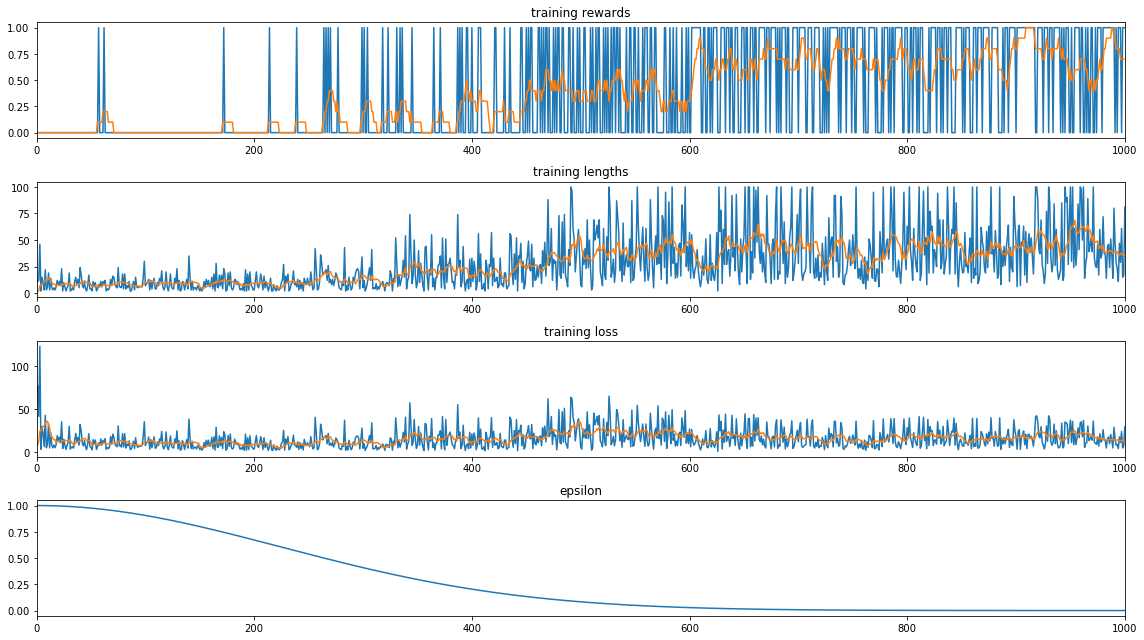

In [8]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16, 9))
plt.subplot(411)
plt.title('training rewards')
plt.plot(range(1, num_episodes+1), rewards)
plt.plot(moving_average(rewards))
plt.xlim([0, num_episodes])
plt.subplot(412)
plt.title('training lengths')
plt.plot(range(1, num_episodes+1), lengths)
plt.plot(range(1, num_episodes+1), moving_average(lengths))
plt.xlim([0, num_episodes])
plt.subplot(413)
plt.title('training loss')
plt.plot(range(1, num_episodes+1), losses)
plt.plot(range(1, num_episodes+1), moving_average(losses))
plt.xlim([0, num_episodes])
plt.subplot(414)
plt.title('epsilon')
plt.plot(range(1, num_episodes+1), epsilons)
plt.xlim([0, num_episodes])
plt.tight_layout(); plt.show()